In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle

In [2]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [4]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 53.07it/s]


In [5]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [6]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [7]:
data.drop(['date'],axis=1,inplace=True)

In [8]:
X_train, y_train = data[data['d']<1914].drop('demand',axis=1), data[data['d']<1914]['demand']
X_valid, y_valid = data[(data['d']>=1914) & (data['d']<1942)].drop('demand',axis=1), data[(data['d']>=1914) & (data['d']<1942)]['demand']
X_test = data[data['d']>=1942].drop('demand',axis=1)

In [9]:
def rmse(pred,value):
    return np.sqrt(((pred-value)**2).mean())

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform,glorot_normal


In [13]:
def Time_series_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape = (input_shape,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Conv1D(50,3,strides=1, padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(25,3,strides=1, padding='same',activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu',kernel_initializer=glorot_uniform(seed=42)))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation = 'relu',kernel_initializer=glorot_uniform(seed=42)))
    model.add(Dense(1, activation='linear'))
    return model

In [14]:
model = Time_series_model_1(X_train.shape[1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 83, 100)           40800     
                                                                 
 dropout_2 (Dropout)         (None, 83, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 83, 50)            30200     
                                                                 
 dropout_3 (Dropout)         (None, 83, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 83, 50)            7550      
                                                                 
 dropout_4 (Dropout)         (None, 83, 50)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 83, 25)           

In [15]:
from tensorflow.keras.callbacks import *
import os
import datetime
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_error', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_error',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_error', factor = 0.25, patience = 1, verbose = 1,min_lr=0.000001)
callbacks = [reduce_lr,earlystop]

In [16]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(x=X_train, y=y_train,epochs=25,verbose=1,batch_size=256, validation_data=(X_valid, y_valid), callbacks=callbacks)

2022-11-16 04:27:14.481793: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4180666840 exceeds 10% of free system memory.
2022-11-16 04:27:18.491712: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4180666840 exceeds 10% of free system memory.


Epoch 1/25
49189/49189 [==============================] - 844s 17ms/step - loss: 0.3259 - root_mean_squared_error: 0.5709 - val_loss: 0.1586 - val_root_mean_squared_error: 0.3982 - lr: 0.0010
Epoch 2/25
49189/49189 [==============================] - ETA: 0s - loss: 0.2290 - root_mean_squared_error: 0.4785
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
49189/49189 [==============================] - 835s 17ms/step - loss: 0.2290 - root_mean_squared_error: 0.4785 - val_loss: 0.3726 - val_root_mean_squared_error: 0.6104 - lr: 0.0010
Epoch 3/25
49189/49189 [==============================] - 834s 17ms/step - loss: 0.0969 - root_mean_squared_error: 0.3112 - val_loss: 0.1440 - val_root_mean_squared_error: 0.3795 - lr: 2.5000e-04
Epoch 4/25
49188/49189 [============================>.] - ETA: 0s - loss: 0.0682 - root_mean_squared_error: 0.2612
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
49189/49189 [==============================] - 833

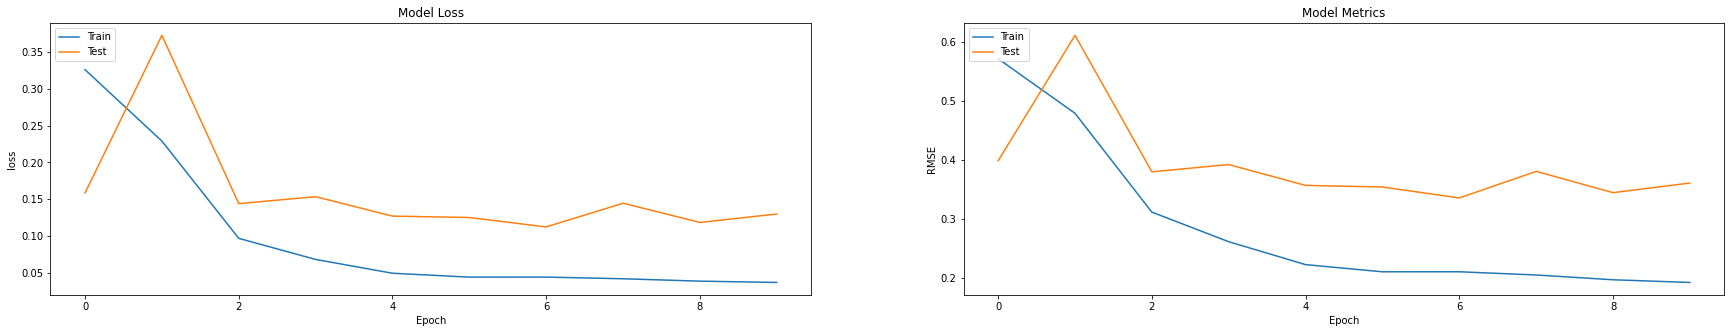

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
def Time_series_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(units=250, return_sequences=True, input_shape = (input_shape,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Conv1D(50,3,strides=1, padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(25,3,strides=1, padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu',kernel_initializer=glorot_uniform(seed=42)))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dropout(0.05))
    model.add(Dense(8, activation = 'relu',kernel_initializer=glorot_uniform(seed=42)))
    model.add(Dense(1, activation='linear'))
    return model

In [12]:
model = Time_series_model_2(X_train.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 83, 250)           252000    
                                                                 
 dropout (Dropout)           (None, 83, 250)           0         
                                                                 
 lstm_1 (LSTM)               (None, 83, 150)           240600    
                                                                 
 dropout_1 (Dropout)         (None, 83, 150)           0         
                                                                 
 lstm_2 (LSTM)               (None, 83, 100)           100400    
                                                                 
 dropout_2 (Dropout)         (None, 83, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 83, 50)            1

In [13]:
from tensorflow.keras.callbacks import *
import os
import datetime
filepath="weights_2.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_error', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_error',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_error', factor = 0.25, patience = 1, verbose = 1,min_lr=0.000001)
callbacks = [reduce_lr,earlystop,checkpoint]

In [14]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(x=X_train, y=y_train,epochs=25,verbose=1,batch_size=512, validation_data=(X_valid, y_valid), callbacks=callbacks)

2022-11-18 08:20:52.846003: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4180666840 exceeds 10% of free system memory.
2022-11-18 08:20:57.689875: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4180666840 exceeds 10% of free system memory.


Epoch 1/25


2022-11-18 08:21:12.554549: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-18 08:21:12.554619: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-18 08:21:13.288631: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-18 08:21:13.288709: W tensorflow/core/common_runtime/bfc_allocato

24595/24595 [==============================] - ETA: 0s - loss: 0.6153 - root_mean_squared_error: 0.7844

2022-11-18 08:45:58.129050: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-18 08:45:58.129241: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-18 08:45:58.274100: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-18 08:45:58.274177: W tensorflow/core/common_runtime/bfc_allocato


Epoch 1: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


24595/24595 [==============================] - 1546s 62ms/step - loss: 0.6153 - root_mean_squared_error: 0.7844 - val_loss: 0.0679 - val_root_mean_squared_error: 0.2605 - lr: 0.0010
Epoch 2/25
24594/24595 [============================>.] - ETA: 0s - loss: 0.3547 - root_mean_squared_error: 0.5956
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 2: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


24595/24595 [==============================] - 1537s 62ms/step - loss: 0.3547 - root_mean_squared_error: 0.5956 - val_loss: 0.1957 - val_root_mean_squared_error: 0.4424 - lr: 0.0010
Epoch 3/25
24594/24595 [============================>.] - ETA: 0s - loss: 0.1719 - root_mean_squared_error: 0.4146
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 3: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


24595/24595 [==============================] - 1538s 63ms/step - loss: 0.1719 - root_mean_squared_error: 0.4146 - val_loss: 0.0901 - val_root_mean_squared_error: 0.3001 - lr: 2.5000e-04
Epoch 4/25
24594/24595 [============================>.] - ETA: 0s - loss: 0.1311 - root_mean_squared_error: 0.3621
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 4: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


24595/24595 [==============================] - 1537s 62ms/step - loss: 0.1311 - root_mean_squared_error: 0.3621 - val_loss: 0.0917 - val_root_mean_squared_error: 0.3029 - lr: 6.2500e-05
Epoch 4: early stopping


In [15]:
filepath="weights_2.best.hdf1"
model.save(filepath)

INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


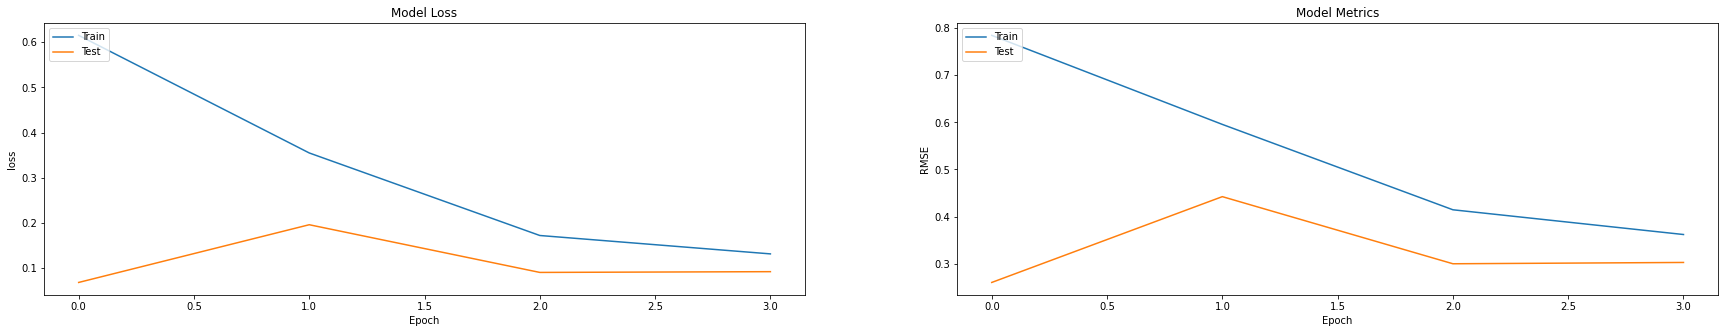

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()